In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm

c = 2.99792458e8 # 光速[m/s]

In [2]:
dx = 0.001 # x方向空間差分間隔[m]
dy = 0.001 # y方向空間差分間隔[m]
dz = 0.001 # z方向空間差分間隔[m]

nx = 30 # x方向計算点数
ny = 30 # y方向計算点数
nz = 200 # z方向計算点数

dt = 0.99/(c * np.sqrt((1.0/dx ** 2 + 1.0/dy ** 2 + 1.0/dz ** 2))) # 時間差分間隔[s] c.f.Courantの安定条件
nt = 2 ** 14 # 計算ステップ数

M = 3
R = 1e-6
pmlN = 8

# 半波長ダイポールアンテナ

In [3]:
# 電気定数初期化と更新係数の計算
eps = np.full((nx, ny, nz), 8.854187817e-12)
mu = np.full((nx, ny, nz), 1.2566370614e-6)
sigma = np.full((nx, ny, nz), 0.0)

for ln in range(pmlN):
    sigma_value = ((pmlN - ln)/pmlN) ** M * ((M + 1) * (-np.log(R))/(2 * pmlN * dx * 120 * np.pi)) # PML吸収境界のsigma計算
    
    sigma[ln : ln + 1, :, :] = sigma_value
    sigma[:, ln : ln + 1, :] = sigma_value
    sigma[:, :, ln : ln + 1] = sigma_value

    sigma[-(ln + 1) : -ln, :, :] = sigma_value
    sigma[:, -(ln + 1) : -ln, :] = sigma_value
    sigma[:, :, -(ln + 1) : -ln] = sigma_value

dhx = dt / (mu * dx) # 式(9) - (11)の右辺係数
dhy = dt / (mu * dy) # 式(9) - (11)の右辺係数
dhz = dt / (mu * dz) # 式(9) - (11)の右辺係数

ce = (2.0 * eps - sigma * dt)/(2.0 * eps + sigma * dt) # 式(12) - (14)の右辺第一項係数
dex = 2.0 * dt /((2.0 * eps * dx) + (sigma * dt * dx)) # 式(12) - (14)の右辺第二項係数
dey = 2.0 * dt /((2.0 * eps * dy) + (sigma * dt * dy)) # 式(12) - (14)の右辺第二項係数
dez = 2.0 * dt /((2.0 * eps * dz) + (sigma * dt * dz)) # 式(12) - (14)の右辺第二項係数

# 電磁界初期化
t = 0.0

E_x = np.zeros(shape=(nx, ny, nz))
E_y = np.zeros(shape=(nx, ny, nz))
E_z = np.zeros(shape=(nx, ny, nz))
H_x = np.zeros(shape=(nx, ny, nz))
H_y = np.zeros(shape=(nx, ny, nz))
H_z = np.zeros(shape=(nx, ny, nz))

tl = np.zeros(nt)
it = np.zeros(nt)
vt = np.zeros(nt)


fig = plt.figure()
for _ in tqdm(range(nt)):
    
    # 電界のz成分を励振
    Vin = np.exp(-((t-(nt//50)*dt)/(dt))**2)
    E_z[nx//2, ny//2, nz//2] = Vin/dz
    t += dt/2
    
    # 電界各成分計算
    E_x = ce * E_x + dez * (H_z - np.roll(H_z, shift=1, axis=1))\
                   - dey * (H_y - np.roll(H_y, shift=1, axis=2))

    E_y = ce * E_y + dey * (H_x - np.roll(H_x, shift=1, axis=2))\
                   - dez * (H_z - np.roll(H_z, shift=1, axis=0))

    E_z = ce * E_z + dez * (H_y - np.roll(H_y, shift=1, axis=0))\
                   - dex * (H_x - np.roll(H_x, shift=1, axis=1))
    
    E_z[nx//2, ny//2, nz//2 - 50: nz//2 + 50] = 0 # 
    
    Eamp = np.sqrt(E_x**2 + E_y**2 + E_z**2)
    
    # 電界のz成分を励振
    Vin = np.exp(-((t-(nt//50)*dt)/(dt*10))**2)
    E_z[nx//2, ny//2, nz//2] = Vin/dz
    t += dt/2
    
    # 磁界各成分計算
    H_x = H_x + dhz * (E_z - np.roll(E_z, shift=-1, axis=1))\
              - dhy * (E_y - np.roll(E_y, shift=-1, axis=2))

    H_y = H_y + dhy * (E_x - np.roll(E_x, shift=-1, axis=2))\
              - dhz * (E_z - np.roll(E_z, shift=-1, axis=0))

    H_z = H_z + dhz * (E_y - np.roll(E_y, shift=-1, axis=0))\
              - dhx * (E_x - np.roll(E_x, shift=-1, axis=1))
    
    
    if _ % 2**8 == 0:
        plt.imshow(Eamp[nx//2, :, :], vmin=0, vmax=1.0, cmap="Reds")
        plt.colorbar()
        plt.savefig(str(_).zfill(8) + ".png")
        plt.close('all')
    
    
    Iin = dy * (H_x[nx//2, ny//2 + 1, nz//2] - H_x[nx//2, ny//2 - 1, nz//2])\
        - dx * (H_y[nx//2 + 1, ny//2, nz//2] - H_y[nx//2 - 1, ny//2, nz//2])
    
    tl[_] = t
    it[_] = Iin
    vt[_] = Vin

100%|████████████████████████████████████| 16384/16384 [12:50<00:00, 22.16it/s]


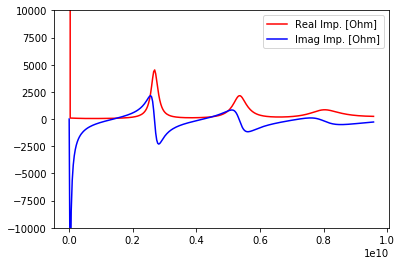

In [16]:
fl = np.linspace(0, 1/dt, nt)

start = 0
end = 300

plt.plot(fl[start:end], np.real(np.fft.fft(vt)/np.fft.fft(it))[start:end], color="red", label="Real Imp. [Ohm]")
plt.plot(fl[start:end], np.imag(np.fft.fft(vt)/np.fft.fft(it))[start:end], color="blue", label="Imag Imp. [Ohm]")
plt.ylim(-10000, 10000)
plt.legend()

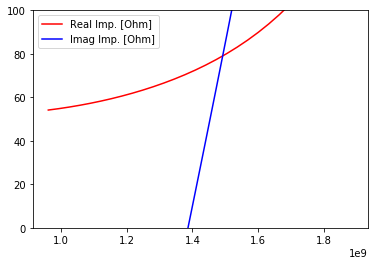

In [17]:
start = 30
end = 60

plt.plot(fl[start:end], np.real(np.fft.fft(vt)/np.fft.fft(it))[start:end], color="red", label="Real Imp. [Ohm]")
plt.plot(fl[start:end], np.imag(np.fft.fft(vt)/np.fft.fft(it))[start:end], color="blue", label="Imag Imp. [Ohm]")
plt.ylim(0, 100)
plt.legend()

In [18]:
for f, imp in zip(fl[start:end]/10**9, np.fft.fft(vt)[start:end]/np.fft.fft(it)[start:end]):
    print(f, imp)

0.9604482269720805 (54.15392915174238-335.9536995869306j)
0.99246316787115 (54.797777965916914-307.202123308505j)
1.0244781087702193 (55.528592564122725-279.38895834438114j)
1.0564930496692886 (56.34809757512963-252.39513104697463j)
1.088507990568358 (57.25875807645114-226.1127590045621j)
1.1205229314674274 (58.26379046964213-200.44331408795782j)
1.1525378723664967 (59.36718659625651-175.29606069894322j)
1.184552813265566 (60.57375145609272-150.58671341516703j)
1.2165677541646354 (61.88915522262105-126.2362692593879j)
1.2485826950637047 (63.32000065940133-102.16997818879679j)
1.2805976359627742 (64.87390752467313-78.31642175807374j)
1.3126125768618435 (66.55961611318078-54.606674727681984j)
1.3446275177609128 (68.3871127359282-30.9735280024253j)
1.3766424586599821 (70.36778070084901-7.3507539321407585j)
1.4086573995590514 (72.51458126340825+16.32760314803386j)
1.4406723404581208 (74.84227011345894+40.12792710447478j)
1.4726872813571903 (77.36765631764287+64.11773634891316j)
1.504702222

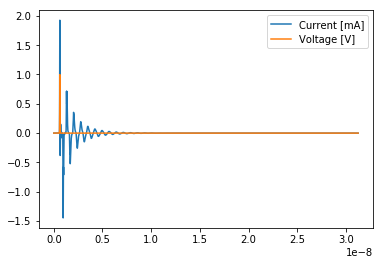

In [7]:
plt.plot(tl, it * 1000, label="Current [mA]")
plt.plot(tl, vt, label="Voltage [V]")
plt.legend()

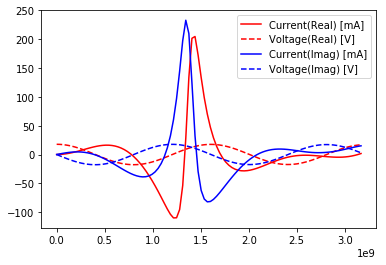

In [13]:
plt.plot(fl[:100], np.real(np.fft.fft(it))[:100] * 1000, label="Current(Real) [mA]", color="red")
plt.plot(fl[:100], np.real(np.fft.fft(vt))[:100], label="Voltage(Real) [V]", color="red", linestyle="dashed")
plt.plot(fl[:100], np.imag(np.fft.fft(it))[:100] * 1000, label="Current(Imag) [mA]", color="blue")
plt.plot(fl[:100], np.imag(np.fft.fft(vt))[:100], label="Voltage(Imag) [V]", color="blue", linestyle="dashed")
plt.legend()